# План работ:

### Буду пробовать три модели CatBoost, нейронку, darts

### 1*) Определиться что буду предсказвать, варианты:
    1.1) Класс - покупать, не покупать, держать
    1.2) Цена на следующеи 5 минут 
    1.3) Цена на следующий час
    1.4) Цена на следующие 2 часа
    1.4) Цена на следующие 5 часов
       1.5) Цена на следующий день


### 2) Взять одну бумагу, попробовать пообучать 
### 3) Взять 5 бумаг из разных областей, попробовать пообучать 

### 4) Выбрать лучшую модель
### 5) Выбрать важные параметры для обучения

### 6) Обучить на всех бумагах 

### 7) Добавить фичи с новостями, смотреть на сколько они влияют относительно новостей про начало СВО и санкции

### 7) Продумать алгоритм работы бота, для торговли в плюс

# !!!добавить признаки по похожим компаниям!!!
# spread_bbo, spread_lv10 - если маленкий спред - то цена акций будет сильно меняться, levels_b, levels_s - в краткосрочную перспекитву 

In [2]:
a = {'a': 1, 'b': 2, 'c': 3,}
del a['a']
a

{'b': 2, 'c': 3}

In [44]:
class EventSample(object):
    callbacks = None
	
    def on(self, EHname, callback):
        if self.callbacks is None:
            self.callbacks = {}
	
        if EHname not in self.callbacks:
            self.callbacks[EHname] = [callback]
        else:
            self.callbacks[EHname].append(callback)
	
    def trigger(self, EHname):
        if self.callbacks is not None and EHname in self.callbacks:
            for callback in self.callbacks[EHname]:
                callback(self)
	
class MClass(EventSample):
    def __init__(self, mess):
        self.mess = mess
	
    def __str__(self):
        return "Message from other class: " + repr(self.mess)
	
def echo(text):
    print (text)
	
MC = MClass("Sample text")
MC.on("sample_event", echo)
MC.trigger("sample_event")

Message from other class: 'Sample text'


In [30]:
from moexalgo import Market, Ticker

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import copy

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.inspection import permutation_importance
from catboost import CatBoostRegressor

from datetime import datetime, timedelta

In [7]:
def get_result_model_training(real, pred, visualization=False):   
    rmse = round(mean_squared_error(real, pred, squared=False), 5)
    r2 = round(r2_score(real, pred), 5)
    mae = round(mean_absolute_error(real, pred), 5)
    mape = round(mean_absolute_percentage_error(real, pred), 5)

    print(f'MAE: {mae}\nR2: {r2}\nRMSE: {rmse}\nMAPE: {mape* 100} %\n')
    
    print(f'\nМедианное значение {round(real.median(), 5)}\nСредние значение {round(real.mean(), 5)}\n')

    if visualization:
        fig, ax = plt.subplots(1, 2, figsize=(18, 7))
        
        sns.scatterplot(x=pred, y=real, ax=ax[0])
        ax[0].plot((real.min(), real.max()), (real.min(), real.max()), color='red')
        ax[0].set_title('График рассеяния на модели', fontsize=20)
        ax[0].set_xlabel('Прогноз', fontsize=15)
        ax[0].set_ylabel('Реальное значение', fontsize=15)

        sns.histplot(data=real - pred, kde=True, ax=ax[1])
        ax[1].set_title('Распределение ошибок', fontsize=20)
        ax[1].set_xlabel('Реальное значение минус прогнозное', fontsize=15)
        ax[1].set_ylabel('')

        plt.show()

### Одна акция - СБЕР

In [39]:
sber = Ticker('SBER')
candles = sber.candles(date='2020-01-01', till_date='2023-12-02', period='10m')
tradestats = sber.tradestats(date='2020-01-01', till_date='2023-12-02')
orderstats = sber.orderstats(date='2020-01-01', till_date='2023-12-02')
obstats = sber.obstats(date='2020-01-01', till_date='2023-12-02')

In [290]:
a = []
b = []

for col in tradestats:
    if col in orderstats:
        a.append(col)
    if col in obstats:
        b.append(col)
        
c = []
for col in orderstats:
    if col in obstats:
        b.append(col)

print(a)
print(b)
print(c)

['ticker', 'tradedate', 'tradetime', 'systime']
['ticker', 'tradedate', 'tradetime', 'val_b', 'val_s', 'vol_b', 'vol_s', 'systime', 'ticker', 'tradedate', 'tradetime', 'systime']
[]


In [331]:
tradestats_copy = tradestats.copy()
orderstats_copy = orderstats.copy().drop(columns=['ticker', 'tradedate', 'tradetime', 'systime'])
obstats_copy = obstats.copy().drop(columns=['ticker', 'tradedate', 'tradetime', 'val_b', 'val_s', 
                                            'vol_b', 'vol_s', 'systime', 'ticker', 'tradedate', 'tradetime', 'systime'])

tradestats_copy = pd.merge(tradestats_copy, orderstats_copy, left_index=True, right_index=True)
tradestats_copy = pd.merge(tradestats_copy, obstats_copy, left_index=True, right_index=True)

In [332]:
tradestats_copy.drop(columns=['ticker', 'systime'], inplace=True)

In [114]:
tradestats_copy['target'] = tradestats_copy.pr_close.shift(-12)
tradestats_copy = tradestats_copy[:len(tradestats_copy)-12]

NameError: name 'tradestats_copy' is not defined

In [334]:
date_split = datetime.strptime('01-11-2020', "%d-%m-%Y").date()

train = tradestats_copy[tradestats_copy["tradedate"] < date_split].drop(columns=['tradedate', 'tradetime'])
X_train = train.drop(columns=['target'])
y_train = train['target']

test = tradestats_copy[tradestats_copy["tradedate"] >= date_split].drop(columns=['tradedate', 'tradetime'])
X_test = test.drop(columns=['target'])
y_test = test['target']

In [335]:
cbr = CatBoostRegressor(random_state=42, loss_function='MAE', verbose=False)
cbr.fit(X_train, y_train)

pred_cbr = cbr.predict(X_test)

In [ ]:
# MAE: 3.26183
# R2: 0.92618
# RMSE: 6.04994
# MAPE: 0.01182

# MAE: 3.79781
# R2: 0.91459
# RMSE: 6.23931
# MAPE: 1.427 %

# MAE: 3.7706
# R2: 0.92353
# RMSE: 6.11129
# MAPE: 1.398 %

MAE: 4.59283
R2: 0.89261
RMSE: 7.24206
MAPE: 1.706 %


Медианное значение 247.945
Средние значение 250.59333



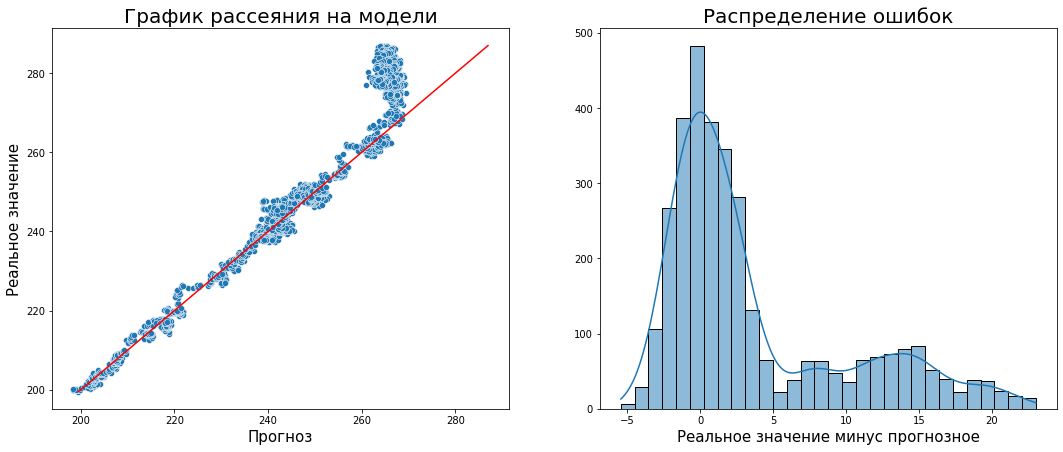

In [336]:
get_result_model_training(y_test, pred_cbr, visualization=True)

Text(0.5, 1.0, 'Feature Importance')

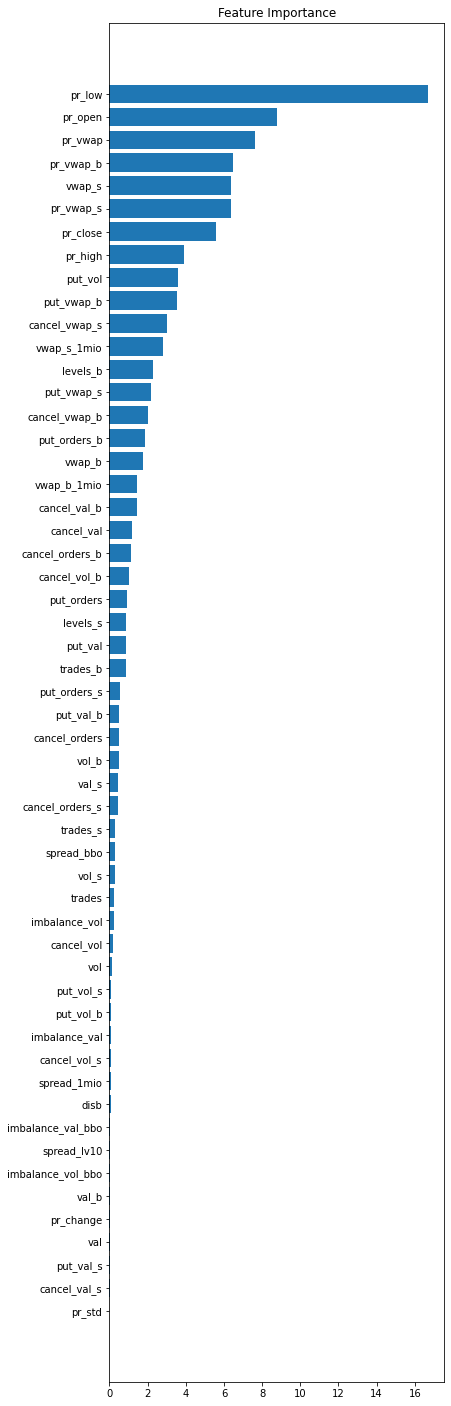

In [338]:
feature_importance = cbr.feature_importances_
sorted_idx = np.argsort(feature_importance)

fig = plt.figure(figsize=(6, 25))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

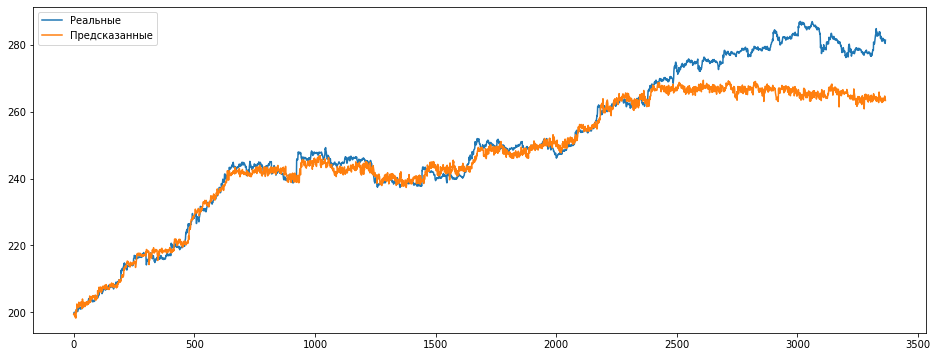

In [337]:
values_to_plot = 200

fig, ax = plt.subplots(1, figsize=(16, 6))
ax.plot(y_test.values)
ax.plot(pred_cbr)
ax.legend(['Реальные', 'Предсказанные'])
plt.show()

### 5 акицй из разных сфер - сбер, яндекс, газпром, фосагро, аэрофлот	

### Нужная ли отмененные заявки? Как их можно использовать? 

In [11]:
tradestats_2023 = pd.read_csv('./data/tradestats_2023.csv', sep=';')
orderstats_2023 = pd.read_csv('./data/orderstats_2023.csv', sep=';')
obstats_2023 = pd.read_csv('./data/obstats_2023.csv', sep=';')

In [12]:
market = Market('stocks')
tickers = market.tickers()

In [377]:
for i, r in tickers.iterrows():
    for comp in ['сбер', 'yandex', 'газпром', 'фосагро', 'аэрофлот']:
        if comp in r.shortname.lower():
            print(r.ticker, r.shortname)

AFLT Аэрофлот
GAZP ГАЗПРОМ ао
PHOR ФосАгро ао
SBER Сбербанк
SBERP Сбербанк-п
YNDX Yandex clA


In [15]:
name_tickers =  ('AFLT', 'GAZP', 'YNDX')
tradestats_2023_5_stocks = tradestats_2023[tradestats_2023.secid.isin(name_tickers)]
orderstats_2023_5_stocks = orderstats_2023[orderstats_2023.secid.isin(name_tickers)]
obstats_2023_5_stocks = obstats_2023[obstats_2023.secid.isin(name_tickers)]

del tradestats_2023, orderstats_2023, obstats_2023

In [16]:
print(tradestats_2023_5_stocks.shape)
print(orderstats_2023_5_stocks.shape)
print(obstats_2023_5_stocks.shape)

(65832, 23)
(65830, 26)
(65431, 21)


In [7]:
a = []
b = []

for col in tradestats_2023_5_stocks:
    if col in orderstats_2023_5_stocks:
        a.append(col)
    if col in obstats_2023_5_stocks:
        b.append(col)
        
c = []
for col in orderstats_2023_5_stocks:
    if col in obstats_2023_5_stocks:
        c.append(col)

print(a)
print(b)
print(c)

['tradedate', 'tradetime', 'secid', 'SYSTIME']
['tradedate', 'tradetime', 'secid', 'val_b', 'val_s', 'vol_b', 'vol_s', 'SYSTIME']
['tradedate', 'tradetime', 'secid', 'SYSTIME']


In [17]:
tradestats_2023_5_stocks.drop(columns=['SYSTIME'], inplace=True)
orderstats_2023_5_stocks.drop(columns=['SYSTIME'], inplace=True)
obstats_2023_5_stocks.drop(columns=['val_b', 'val_s', 'vol_b', 'vol_s', 'SYSTIME'], inplace=True)

In [18]:
df_3_stocks = tradestats_2023_5_stocks.merge(orderstats_2023_5_stocks, on=['secid', 'tradedate', 'tradetime'], how='left')
df_3_stocks = df_3_stocks.merge(obstats_2023_5_stocks, on=['secid', 'tradedate', 'tradetime'], how='left')

In [19]:
to_drop = ['cancel_val_b', 'cancel_val_s', 'cancel_vol_b', 
'cancel_vol_s', 'cancel_vwap_b', 'cancel_vwap_s', 'cancel_vol', 'cancel_val', 'cancel_orders']
df_3_stocks.drop(columns=to_drop, inplace=True)

In [20]:
df_3_stocks.fillna(-1, inplace=True)

In [21]:
df_3_stocks['target'] = df_3_stocks.groupby('secid').pr_close.shift(-12)
df_3_stocks = df_3_stocks[:len(df_3_stocks)-12*3]

In [22]:
df_3_stocks['tradetime'] = df_3_stocks['tradetime'].apply(lambda x: datetime.strptime(x, '%H:%M:%S').time())
df_3_stocks['tradedate'] = df_3_stocks['tradedate'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())

In [23]:
date_split = datetime.strptime('01-09-2023', "%d-%m-%Y").date()

train = df_3_stocks[df_3_stocks["tradedate"] < date_split].drop(columns=['tradedate', 'tradetime'])
X_train = train.drop(columns=['target'])
y_train = train['target']

test = df_3_stocks[df_3_stocks["tradedate"] >= date_split].drop(columns=['tradedate', 'tradetime'])
X_test = test.drop(columns=['target'])
y_test = test['target']

### CatBoost

In [182]:
cbr = CatBoostRegressor(random_state=42, loss_function='MAE', verbose=False, cat_features=['secid'])
cbr.fit(X_train, y_train)

pred_cbr = cbr.predict(X_test)

In [ ]:
MAE: 0.44188
R2: 0.981
RMSE: 0.62927
MAPE: 0.259 %


Медианное значение 169.58
Средние значение 170.72252

MAE: 5.20794
R2: -12.64666
RMSE: 16.86266
MAPE: 3.0140000000000002 %


Медианное значение 169.58
Средние значение 170.72252



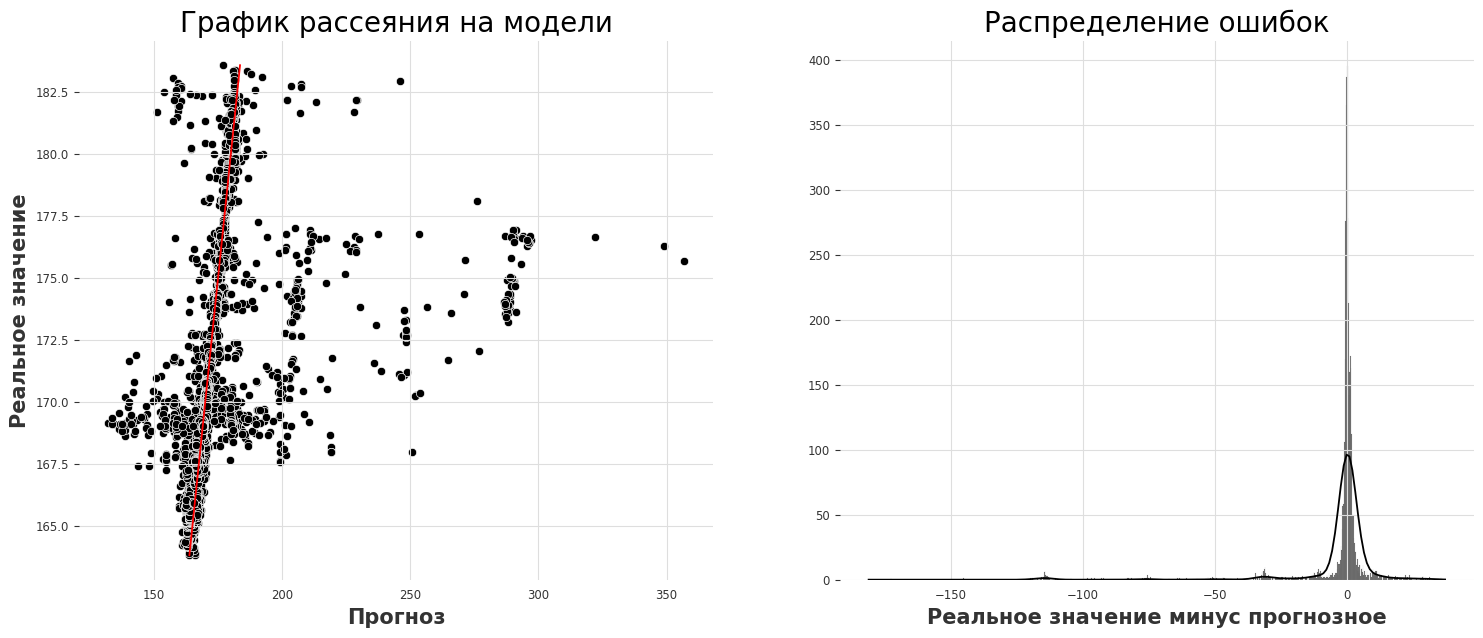

In [183]:
ind_cur_stock = X_test[X_test.secid == 'GAZP'].index
real_to_plot = y_test[ind_cur_stock]
pred_to_plot = pd.Series(pred_cbr, index=y_test.index)[ind_cur_stock]

get_result_model_training(real_to_plot, pred_to_plot, visualization=True)

Text(0.5, 1.0, 'Feature Importance')

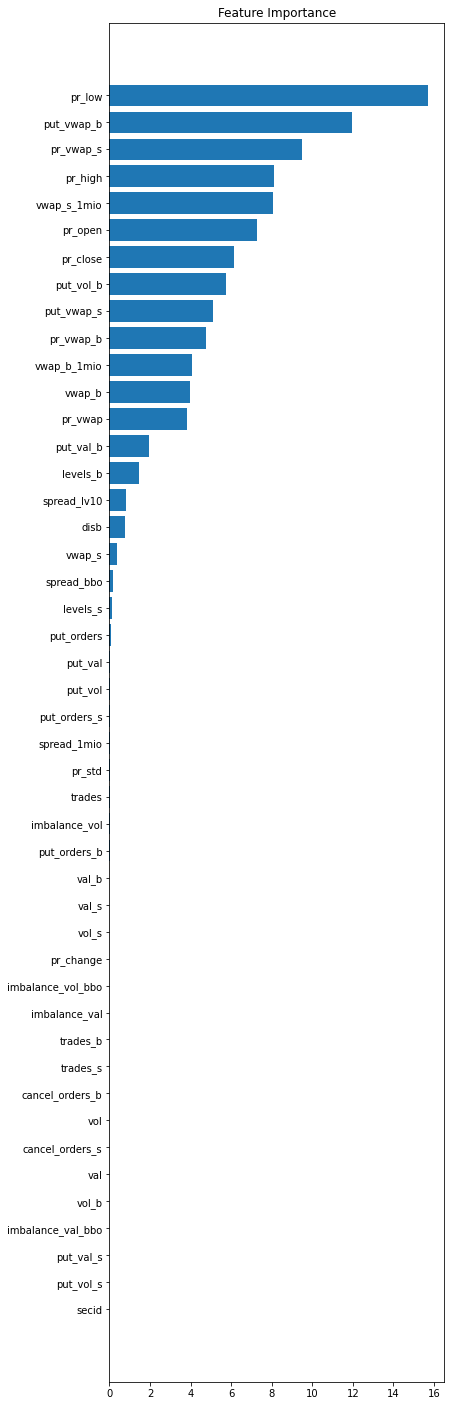

In [104]:
feature_importance = cbr.feature_importances_
sorted_idx = np.argsort(feature_importance)

fig = plt.figure(figsize=(6, 25))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

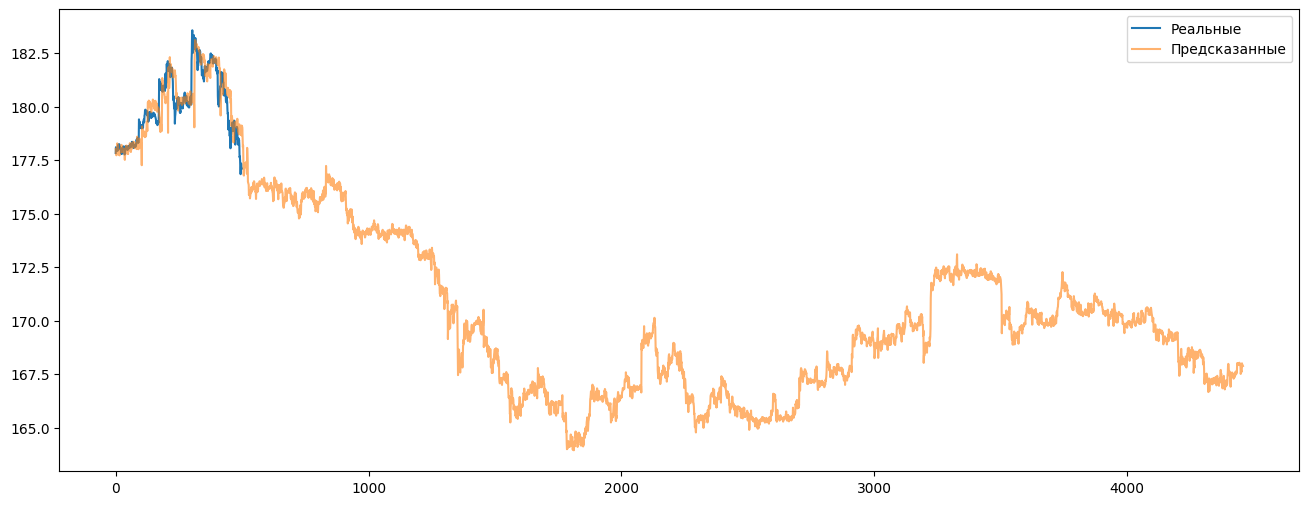

In [154]:
values_to_plot = 500
ind_cur_stock = X_test[X_test.secid == 'GAZP'].index

real_to_plot = y_test[ind_cur_stock].values[:values_to_plot]
# pred_to_plot = pd.Series(pred_cbr, index=y_test.index)[ind_cur_stock].values[:values_to_plot]

fig, ax = plt.subplots(1, figsize=(16, 6))
ax.plot(real_to_plot)
ax.plot(pred_cbr, alpha=0.6)
ax.legend(['Реальные', 'Предсказанные'])
plt.show()

## Нейроночка

### Прогнозировать N следующих значения закрытия, если совпадает факт и прогноз или прогноз меньше чем факт то не продаем, инчае продаем если сильно в минус ошибаемся 

In [9]:
import math
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Flatten, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ReduceLROnPlateau

In [164]:
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(16, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.00000001)

In [156]:
X_train_net = np.array(X_train[X_train.secid == 'GAZP'].drop(columns={'secid'}))
X_train_net = np.reshape(list(X_train_net), (17472, 1, 45))
y_train_net = np.array(y_train[X_train[X_train.secid == 'GAZP'].index])

X_test_net = np.array(X_test[X_test.secid == 'GAZP'].drop(columns={'secid'}))
X_test_net = np.reshape(list(X_test_net), (4460, 1, 45))
y_test_net = np.array(y_test)

In [165]:
history = model.fit(X_train_net, y_train_net, 
                    epochs=60, 
                    batch_size=16, 
                    verbose=2, 
                    validation_split=0.1, 
                    callbacks=[reduce_lr], 
                    shuffle=False)

Epoch 1/60
983/983 - 12s - loss: 2541415.5000 - val_loss: 286391.5938 - lr: 1.0000e-04 - 12s/epoch - 12ms/step
Epoch 2/60
983/983 - 5s - loss: 372870.9688 - val_loss: 98161.9766 - lr: 1.0000e-04 - 5s/epoch - 5ms/step
Epoch 3/60
983/983 - 5s - loss: 229116.1250 - val_loss: 78062.0156 - lr: 1.0000e-04 - 5s/epoch - 5ms/step
Epoch 4/60
983/983 - 5s - loss: 45138.9648 - val_loss: 15823.6738 - lr: 1.0000e-04 - 5s/epoch - 5ms/step
Epoch 5/60
983/983 - 5s - loss: 43965.7578 - val_loss: 3330.9685 - lr: 1.0000e-04 - 5s/epoch - 5ms/step
Epoch 6/60
983/983 - 5s - loss: 5965.0312 - val_loss: 590.5427 - lr: 1.0000e-04 - 5s/epoch - 5ms/step
Epoch 7/60


KeyboardInterrupt: 

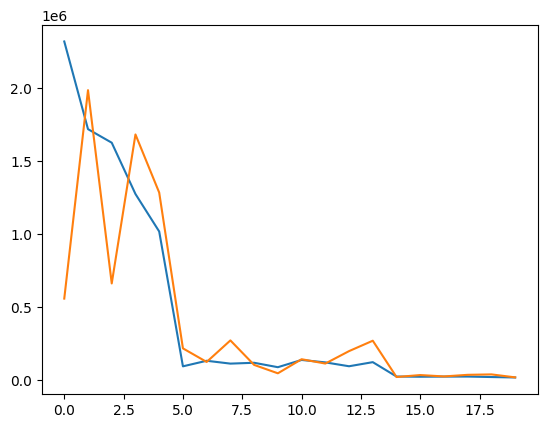

In [132]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [65]:
X_test

,secid,pr_open,pr_high,pr_low,pr_close,pr_std,vol,val,trades,pr_vwap,...,levels_b,levels_s,imbalance_vol_bbo,imbalance_val_bbo,imbalance_vol,imbalance_val,vwap_b,vwap_s,vwap_b_1mio,vwap_s_1mio
52416,AFLT,44.02,44.09,43.90,43.96,0.0007,12270.0,5396847.0,184.0,43.98,...,378.0,473.0,-0.55,-0.55,-0.19,-0.25,41.66,46.54,43.94,44.05
52417,GAZP,178.09,178.20,178.04,178.04,0.0001,25508.0,45432923.0,765.0,178.11,...,1074.0,900.0,-0.09,-0.09,-0.00,-0.04,172.88,183.67,178.10,178.14
52418,YNDX,2690.00,2696.00,2689.80,2693.80,0.0001,18837.0,50740177.0,1034.0,2693.60,...,699.0,606.0,-0.13,-0.13,-0.27,-0.31,2554.60,2797.00,2692.70,2694.40
52419,AFLT,43.95,43.97,43.92,43.97,0.0002,4336.0,1905564.0,132.0,43.95,...,388.0,500.0,0.00,0.00,-0.16,-0.21,41.98,46.35,43.92,43.99
52420,GAZP,178.08,178.14,178.00,178.08,0.0001,18047.0,32134311.0,487.0,178.06,...,1082.0,914.0,0.17,0.17,-0.08,-0.11,172.91,183.58,178.06,178.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65791,GAZP,167.60,167.62,167.56,167.61,0.0000,3384.0,5671211.0,212.0,167.59,...,993.0,1082.0,0.17,0.17,-0.31,-0.34,163.65,175.31,167.57,167.62
65792,YNDX,2595.00,2596.80,2594.00,2595.60,0.0001,758.0,1967285.0,87.0,2595.40,...,837.0,783.0,-0.27,-0.27,-0.14,-0.18,2499.40,2732.00,2594.40,2596.20
65793,AFLT,39.07,39.29,39.03,39.25,0.0003,36306.0,14214222.0,212.0,39.15,...,444.0,648.0,0.03,0.03,0.03,-0.04,36.95,41.83,39.09,39.13
65794,GAZP,167.61,167.65,167.56,167.58,0.0000,2274.0,3811583.0,182.0,167.62,...,990.0,1079.0,0.06,0.06,-0.31,-0.34,163.64,175.31,167.58,167.63


In [133]:
model.evaluate(X_test_net, y_test_net)

419/419 [==============================] - 1s 3ms/step - loss: 14004.1113


14004.111328125

In [135]:
pred_network = model.predict(X_test_net)
get_result_model_training(y_test_net, pred_network, visualization=True)

419/419 [==============================] - 1s 3ms/step


ValueError: Found array with dim 3. None expected <= 2.

In [ ]:
model.evaluate(X_test, y_test)

plt.plot(model.predict(X_test)[0], figure=plt.figure(figsize=(25,8)), label='предсказанные')
plt.plot(np.array(y_test[0].reshape(1, 24)[0]), label='реальные')

plt.legend(prop={'size': 15})

## Библиотека Darts

In [179]:
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from functools import reduce

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    RegressionEnsembleModel,
    RegressionModel,
    Theta,
    FFT
)

from darts.metrics import mape, mase
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.datasets import AirPassengersDataset

In [181]:
series

<TimeSeries (DataArray) (Month: 144, component: 1, sample: 1)>
array([[[112.]],

       [[118.]],

       [[132.]],

       [[129.]],

       [[121.]],

       [[135.]],

       [[148.]],

       [[148.]],

       [[136.]],

       [[119.]],

...

       [[419.]],

       [[461.]],

       [[472.]],

       [[535.]],

       [[622.]],

       [[606.]],

       [[508.]],

       [[461.]],

       [[390.]],

       [[432.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1949-01-01 1949-02-01 ... 1960-12-01
  * component  (component) object '#Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

model ExponentialSmoothing() obtains MAPE: 5.03%


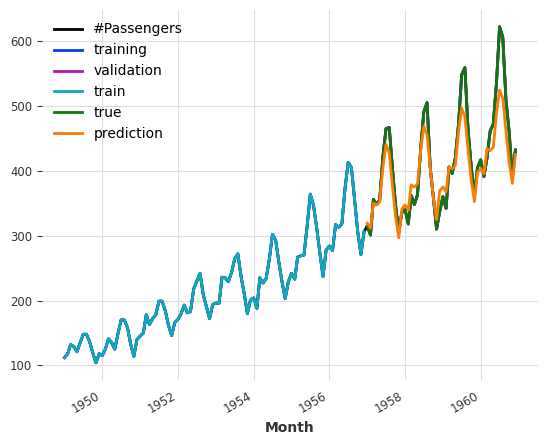

ImportError: The `Prophet` module could not be imported. To enable Prophet support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


ImportError: The `Prophet` module could not be imported. To enable Prophet support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md

In [180]:
## Load the pre-loaded Dataset
series = AirPassengersDataset().load()
series.plot()

## Split train and test data
train, val = series.split_before(pd.Timestamp('19570101'))
train.plot(label='training')
val.plot(label='validation')
plt.legend();

## Fitting multiple models and checking the MAPE
def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print('model {} obtains MAPE: {:.2f}%'.format(model, mape(val, forecast)))
    
    train.plot(label='train')
    val.plot(label='true')
    forecast.plot(label='prediction')
    plt.legend();

    plt.show()

eval_model(ExponentialSmoothing())
eval_model(Prophet())
eval_model(AutoARIMA())
eval_model(Theta())


## Tuning the theta parameter to see if MAPE reduces
## Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float('inf')
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta
        
## Fitting and predicting again usinh best theta value
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print('The MAPE is: {:.2f}, with theta = {}.'.format(mape(val, pred_best_theta), best_theta))

## Visualize 
train.plot(label='train')
val.plot(label='true')
pred_best_theta.plot(label='prediction')
plt.legend();